In [1]:
import gymnasium as gym
import text_flappy_bird_gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

class MonteCarloAgent:
    def __init__(self, 
                 action_space, 
                 gamma=1.0, 
                 epsilon=0.1):
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_space = action_space
        self.Q = defaultdict(float)
        self.N = defaultdict(int)

    def policy(self, state):
        if random.random() < self.epsilon:
            return self.action_space.sample()
        else:
            values = [(a, self.Q[(state, a)]) for a in range(self.action_space.n)]
            best_action = max(values, key=lambda x: x[1])[0]
            return best_action

    def update(self, episode):
        visited_pairs = set()
        G = 0.0
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = self.gamma * G + r
            if (s, a) not in visited_pairs:
                visited_pairs.add((s, a))
                self.N[(s, a)] += 1
                self.Q[(s, a)] += (G - self.Q[(s, a)]) / self.N[(s, a)]

def run_episode(env, agent):
    obs, _ = env.reset()
    episode_data = []
    done = False
    total_reward = 0.0
    while not done:
        action = agent.policy(obs)
        next_obs, reward, done, truncated, info = env.step(action)
        episode_data.append((obs, action, reward))
        obs = next_obs
        total_reward += reward
    score = info['score']
    agent.update(episode_data)
    return total_reward, score


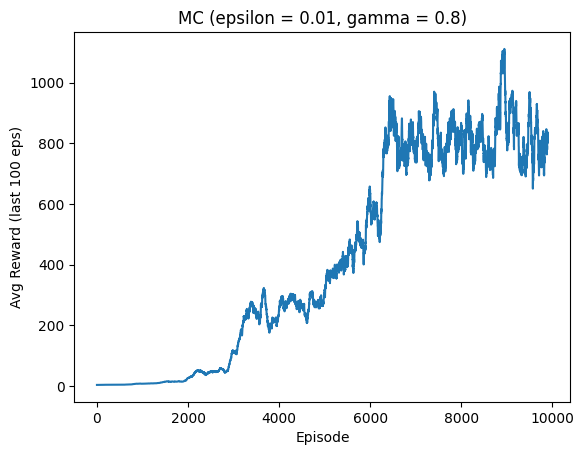

In [2]:
def train_monte_carlo(env_name="TextFlappyBird-v0", 
                      episodes=1000,
                      gamma=1.0,
                      epsilon=0.1):
    env = gym.make(env_name, height=15, width=20, pipe_gap=4)
    agent = MonteCarloAgent(env.action_space, gamma=gamma, epsilon=epsilon)

    all_rewards = []
    all_score = []
    for i in range(episodes):
        episode_reward, score = run_episode(env, agent)
        all_rewards.append(episode_reward)
        all_score.append(score)
    env.close()
    return agent, all_rewards, all_score

agent_MC, rewards, scores = train_monte_carlo(episodes=10000, epsilon=0.01, gamma=0.8)

window_size = 100
smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
plt.figure()
plt.plot(smoothed)
plt.xlabel("Episode")
plt.ylabel("Avg Reward (last 100 eps)")
plt.title("MC (epsilon = 0.01, gamma = 0.8)")
plt.show()

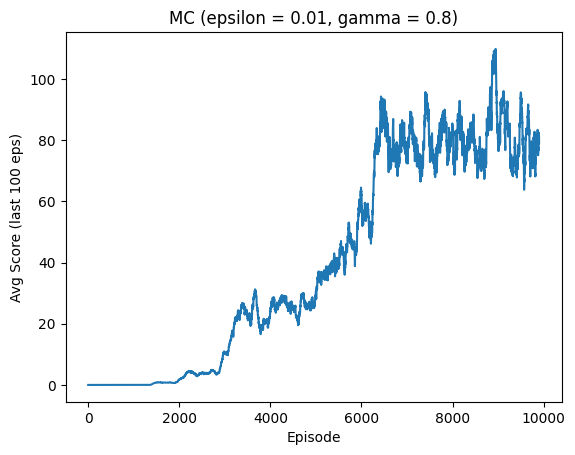

In [3]:
window_size = 100
smoothed = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
plt.figure()
plt.plot(smoothed)
plt.xlabel("Episode")
plt.ylabel("Avg Score (last 100 eps)")
plt.title("MC (epsilon = 0.01, gamma = 0.8)")
plt.show()

In [4]:
def sweep_epsilon(env_name="TextFlappyBird-v0", 
                  episodes=2000, 
                  gamma=1.0,
                  epsilon_values=[0.01, 0.05, 0.1, 0.2]):
    plt.figure()
    
    for eps in epsilon_values:
        _, rewards, scores = train_monte_carlo(env_name=env_name, 
                                       episodes=episodes, 
                                       gamma=gamma, 
                                       epsilon=eps)
        window_size = 100
        smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        
        plt.plot(smoothed, label=f"epsilon={eps}")
    
    plt.xlabel("Episode")
    plt.ylabel("Reward (smoothed over 50)")
    plt.title("Monte Carlo - Sweep over epsilon")
    plt.legend()
    plt.show()

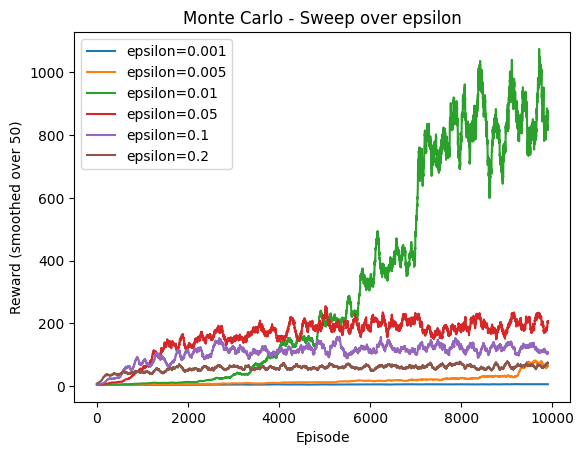

In [5]:
sweep_epsilon(
    env_name="TextFlappyBird-v0", 
    episodes=10000, 
    gamma=0.8,
    epsilon_values=[0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
)

In [6]:
def sweep_gamma(env_name="TextFlappyBird-v0", 
                episodes=10000, 
                epsilon=0.1,
                gamma_values=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    
    plt.figure()
    
    for gamma in gamma_values:
        _, rewards, scores = train_monte_carlo(env_name=env_name,
                                       episodes=episodes,
                                       gamma=gamma,
                                       epsilon=epsilon)
        window_size = 100
        smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        
        plt.plot(smoothed, label=f"gamma={gamma}")
    
    plt.xlabel("Episode")
    plt.ylabel("Reward (smoothed)")
    plt.title(f"Monte Carlo - Sweep over gamma (epsilon={epsilon})")
    plt.legend()
    plt.show()

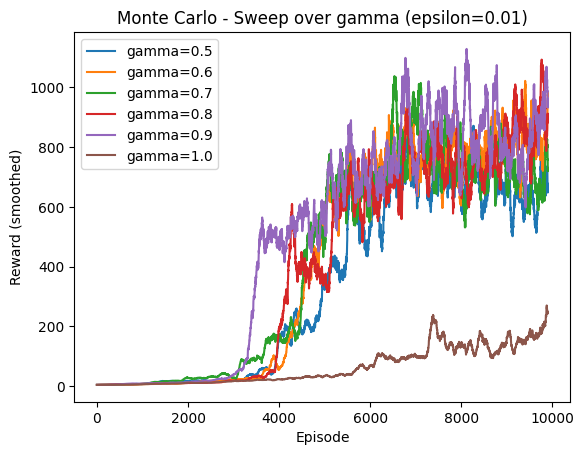

In [7]:
sweep_gamma(
    env_name="TextFlappyBird-v0",
    episodes=10000, 
    epsilon=0.01,
    gamma_values=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

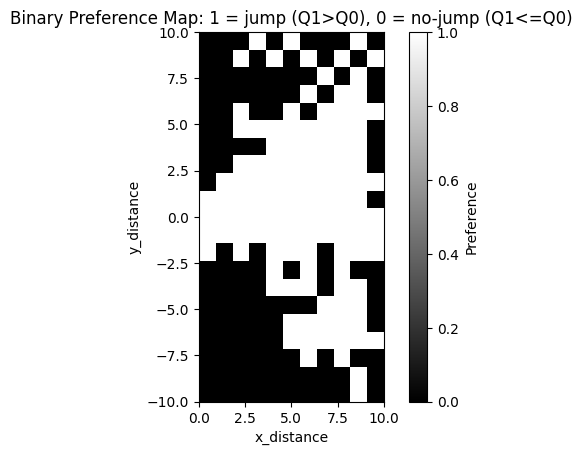

In [8]:
def visualize_Q_binary(agent, x_range=(-10, 10), y_range=(-10, 10)):
    
    x_vals = range(x_range[0], x_range[1] + 1)
    y_vals = range(y_range[0], y_range[1] + 1)
    
    binary_pref = np.zeros((len(y_vals), len(x_vals)))
    
    for i, y in enumerate(y_vals):
        for j, x in enumerate(x_vals):
            state = (x, y)
            q0 = agent.Q[(state, 0)]
            q1 = agent.Q[(state, 1)]
            
            if q1 > q0:
                binary_pref[i, j] = 1
            else:
                binary_pref[i, j] = 0
    
    plt.figure()
    plt.imshow(binary_pref, origin='lower',
               extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
               cmap='gray')
    plt.title("Binary Preference Map: 1 = jump (Q1>Q0), 0 = no-jump (Q1<=Q0)")
    plt.xlabel("x_distance")
    plt.ylabel("y_distance")
    plt.colorbar(label="Preference")
    plt.show()



if __name__ == "__main__":
    agent, rewards, scores = train_monte_carlo(episodes=10000, epsilon=0.01, gamma=0.8)
    visualize_Q_binary(agent, x_range=(0, 10), y_range=(-10, 10))


In [9]:
class SarsaLambdaAgent:
    def __init__(self, action_space, alpha=0.1, gamma=0.99, lam=0.9, epsilon=0.1):
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.lam = lam
        self.epsilon = epsilon
        
        self.Q = defaultdict(float)
    
    def policy(self, state):
        if random.random() < self.epsilon:
            return self.action_space.sample()
        else:
            best_a = None
            best_q = float('-inf')
            for a in range(self.action_space.n):
                q_val = self.Q[(state, a)]
                if q_val > best_q:
                    best_q = q_val
                    best_a = a
            return best_a
    
    def reset_traces(self):
        self.e = defaultdict(float)
    
    def update_step(self, s, a, r, s_next, a_next):
        delta = r + self.gamma * self.Q[(s_next, a_next)] - self.Q[(s, a)]
        
        self.e[(s, a)] += 1.0
        
        for (x, y) in self.e.keys():
            self.Q[(x, y)] += self.alpha * delta * self.e[(x, y)]
            self.e[(x, y)] *= self.gamma * self.lam
        




In [10]:
def run_sarsa_lambda(env_name="TextFlappyBird-v0",
                     episodes=1000,
                     alpha=0.1,
                     gamma=0.99,
                     lam=0.9,
                     epsilon=0.1,
                     height=15, width=20, pipe_gap=4):

    env = gym.make(env_name, height=height, width=width, pipe_gap=pipe_gap)
    
    agent = SarsaLambdaAgent(env.action_space, alpha, gamma, lam, epsilon)
    
    all_rewards = []
    all_scores = []
    for ep in range(episodes):
        obs, _ = env.reset()
        agent.reset_traces()
        
        action = agent.policy(obs)
        
        total_reward = 0.0
        done = False
        
        while not done:
            next_obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            
            if not done:
                next_action = agent.policy(next_obs)
            else:
                next_action = 0 
            
            agent.update_step(obs, action, reward, next_obs, next_action)
            
            obs = next_obs
            action = next_action
        
        all_rewards.append(total_reward)
        all_scores.append(info['score'])
    env.close()
    return agent, all_rewards, all_scores

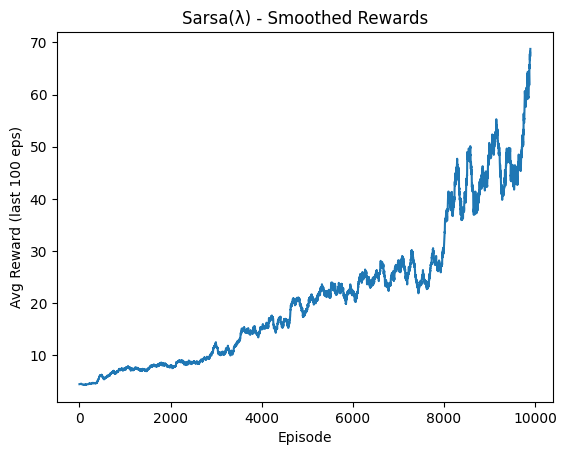

In [11]:
agent_Sarsa, rewards, scores = run_sarsa_lambda(
    env_name="TextFlappyBird-v0",
    episodes=10000,
    alpha=0.1,
    gamma=0.99,
    lam=0.9,
    epsilon=0.1,
    height=15, width=20, pipe_gap=4
)

window_size = 100
smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
plt.figure()
plt.plot(smoothed)
plt.xlabel("Episode")
plt.ylabel("Avg Reward (last 100 eps)")
plt.title("Sarsa(λ) - Smoothed Rewards")
plt.show()


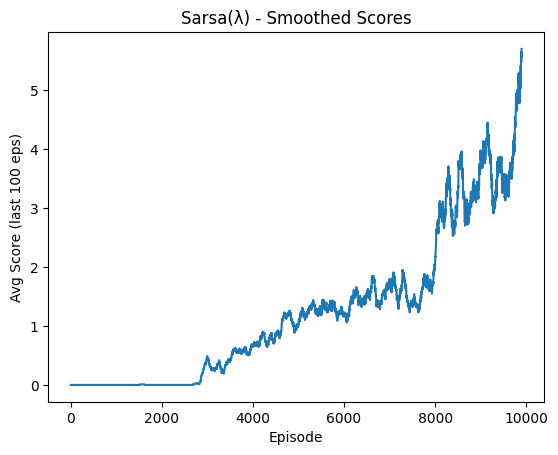

In [12]:
window_size = 100
smoothed = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
plt.figure()
plt.plot(smoothed)
plt.xlabel("Episode")
plt.ylabel("Avg Score (last 100 eps)")
plt.title("Sarsa(λ) - Smoothed Scores")
plt.show()

In [13]:
def sweep_alpha(env_name="TextFlappyBird-v0",
                episodes=5000,
                alpha_values=[0.01, 0.05, 0.1, 0.2],
                gamma=0.99,
                lam=0.9,
                epsilon=0.1,
                height=15, width=20, pipe_gap=4):
    plt.figure()
    
    for alpha in alpha_values:
        _, rewards, scores = run_sarsa_lambda(env_name=env_name,
                                      episodes=episodes,
                                      alpha=alpha,
                                      gamma=gamma,
                                      lam=lam,
                                      epsilon=epsilon,
                                      height=height,
                                      width=width,
                                      pipe_gap=pipe_gap)
        window_size = 100
        smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        
        plt.plot(smoothed, label=f"alpha={alpha}")
    
    plt.title(f"Sarsa(lambda) - Sweep alpha (gamma={gamma}, lam={lam}, eps={epsilon})")
    plt.xlabel("Episode")
    plt.ylabel("Reward (smoothed)")
    plt.legend()
    plt.show()


In [14]:
def sweep_epsilon(env_name="TextFlappyBird-v0",
                  episodes=5000,
                  epsilon_values=[0.01, 0.05, 0.1, 0.2],
                  alpha=0.1,
                  gamma=0.99,
                  lam=0.9,
                  height=15, width=20, pipe_gap=4):
    plt.figure()
    
    for eps in epsilon_values:
        _, rewards, scores = run_sarsa_lambda(env_name=env_name,
                                      episodes=episodes,
                                      alpha=alpha,
                                      gamma=gamma,
                                      lam=lam,
                                      epsilon=eps,
                                      height=height,
                                      width=width,
                                      pipe_gap=pipe_gap)
        window_size = 100
        smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        
        plt.plot(smoothed, label=f"epsilon={eps}")
    
    plt.title(f"Sarsa(lambda) - Sweep epsilon (alpha={alpha}, gamma={gamma}, lam={lam})")
    plt.xlabel("Episode")
    plt.ylabel("Reward (smoothed)")
    plt.legend()
    plt.show()

In [15]:
def sweep_gamma(env_name="TextFlappyBird-v0",
                episodes=5000,
                gamma_values=[0.9, 0.95, 0.99, 1.0],
                alpha=0.1,
                lam=0.9,
                epsilon=0.1,
                height=15, width=20, pipe_gap=4):
    plt.figure()
    
    for g in gamma_values:
        _, rewards, scores = run_sarsa_lambda(env_name=env_name,
                                      episodes=episodes,
                                      alpha=alpha,
                                      gamma=g,
                                      lam=lam,
                                      epsilon=epsilon,
                                      height=height,
                                      width=width,
                                      pipe_gap=pipe_gap)
        window_size = 100
        smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        
        plt.plot(smoothed, label=f"gamma={g}")
    
    plt.title(f"Sarsa(lambda) - Sweep gamma (alpha={alpha}, lam={lam}, eps={epsilon})")
    plt.xlabel("Episode")
    plt.ylabel("Reward (smoothed)")
    plt.legend()
    plt.show()


In [16]:
def sweep_lambda(env_name="TextFlappyBird-v0",
                 episodes=5000,
                 lambda_values=[0.0, 0.3, 0.6, 0.9, 1.0],
                 alpha=0.1,
                 gamma=0.99,
                 epsilon=0.1,
                 height=15, width=20, pipe_gap=4):
    plt.figure()
    
    for lam in lambda_values:
        _, rewards, scores = run_sarsa_lambda(env_name=env_name,
                                      episodes=episodes,
                                      alpha=alpha,
                                      gamma=gamma,
                                      lam=lam,
                                      epsilon=epsilon,
                                      height=height,
                                      width=width,
                                      pipe_gap=pipe_gap)
        window_size = 100
        smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        
        plt.plot(smoothed, label=f"lambda={lam}")
    
    plt.title(f"Sarsa(lambda) - Sweep lambda (alpha={alpha}, gamma={gamma}, eps={epsilon})")
    plt.xlabel("Episode")
    plt.ylabel("Reward (smoothed)")
    plt.legend()
    plt.show()


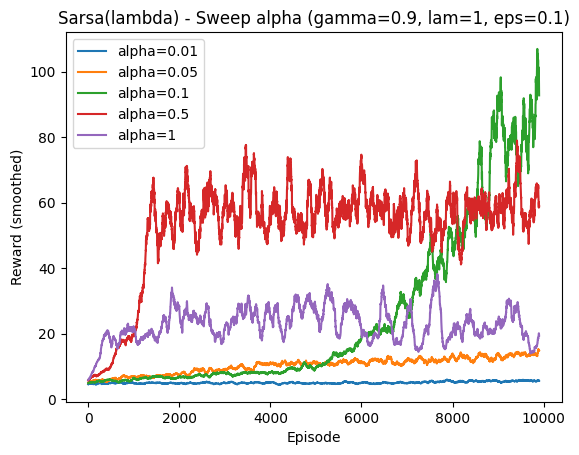

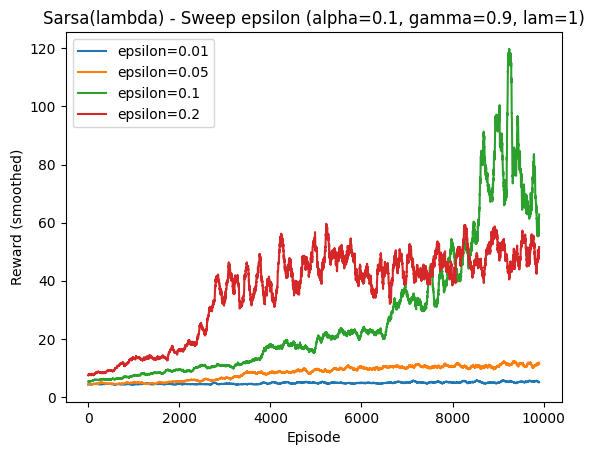

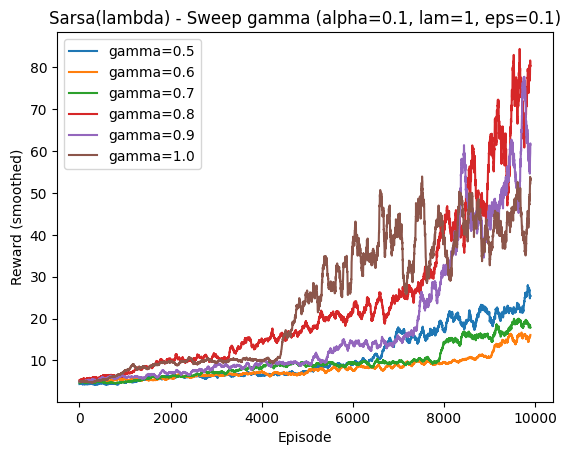

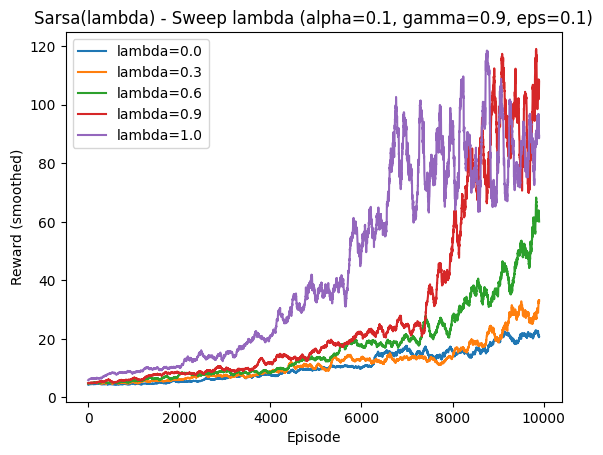

In [17]:
if __name__ == "__main__":
    # Sweep alpha
    sweep_alpha(
        env_name="TextFlappyBird-v0",
        episodes=10000,
        alpha_values=[0.01, 0.05, 0.1, 0.5, 1],
        gamma=0.9,
        lam=1,
        epsilon=0.1
    )
    
    # Sweep epsilon
    sweep_epsilon(
        env_name="TextFlappyBird-v0",
        episodes=10000,
        epsilon_values=[0.01, 0.05, 0.1, 0.2],
        alpha=0.1,
        gamma=0.9,
        lam=1
    )
    
    # Sweep gamma
    sweep_gamma(
        env_name="TextFlappyBird-v0",
        episodes=10000,
        gamma_values=[0.5,0.6, 0.7, 0.8, 0.9, 1.0],
        alpha=0.1,
        lam=1,
        epsilon=0.1
    )
    
    # Sweep lambda
    sweep_lambda(
        env_name="TextFlappyBird-v0",
        episodes=10000,
        lambda_values=[0.0, 0.3, 0.6, 0.9, 1.0],
        alpha=0.1,
        gamma=0.9,
        epsilon=0.1
    )


In [18]:
def visualize_state_value(agent, x_range=(0, 10), y_range=(-10, 10)):    
    x_vals = range(x_range[0], x_range[1] + 1)
    y_vals = range(y_range[0], y_range[1] + 1)
    
    state_values = np.zeros((len(y_vals), len(x_vals)))
    
    for i, y in enumerate(y_vals):
        for j, x in enumerate(x_vals):
            state = (x, y)
            q_values = [agent.Q[(state, a)] for a in range(agent.action_space.n)]
            state_values[i, j] = max(q_values)
    
    plt.figure()
    plt.imshow(state_values, origin='lower', 
               extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
               aspect='auto')
    plt.colorbar(label='V(s)')
    plt.title('State-Value Function for Sarsa($\\lambda$) Agent')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

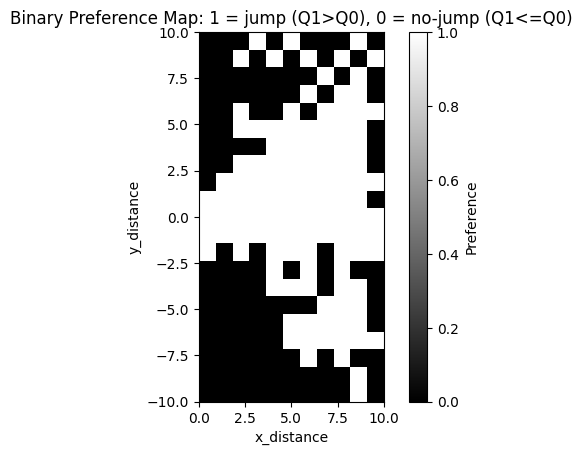

In [19]:
agent_Sarsa, rewards, scores = run_sarsa_lambda(
    env_name="TextFlappyBird-v0",
    episodes=10000,
    alpha=0.1,
    gamma=0.9,
    lam=1,
    epsilon=0.1,
    height=15, width=20, pipe_gap=4
)
visualize_Q_binary(agent, x_range=(0, 10), y_range=(-10, 10))

In [20]:
def test_monte_carlo_agent(agent, env_name="TextFlappyBird-v0", episodes=10, height=15, width=20, pipe_gap=4):
    env = gym.make(env_name, height=height, width=width, pipe_gap=pipe_gap)
    test_scores = []
    
    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action = agent.policy(obs)
            next_obs, reward, done, truncated, info = env.step(action)
            obs = next_obs
        score = info['score']
        test_scores.append(score)
    env.close()
    return test_scores


def test_sarsa_agent(agent, env_name="TextFlappyBird-v0", episodes=10, height=15, width=20, pipe_gap=4):
    env = gym.make(env_name, height=height, width=width, pipe_gap=pipe_gap)
    test_scores = []
    
    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0.0
        total_score = 0
        while not done:
            action = agent.policy(obs)
            next_obs, reward, done, truncated, info = env.step(action)
            obs = next_obs
        score = info['score']
        test_scores.append(score)
    
    env.close()
    return test_scores


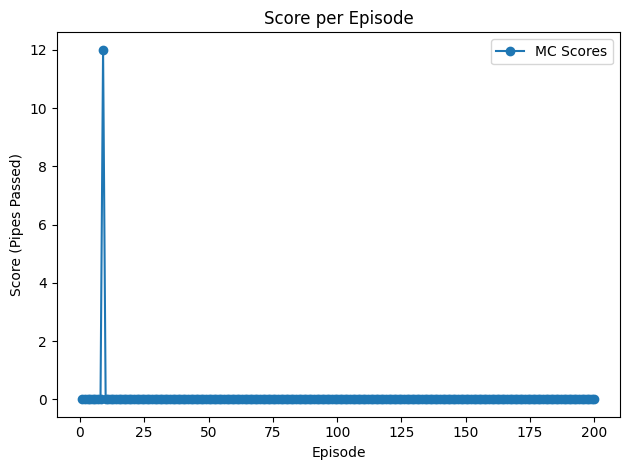

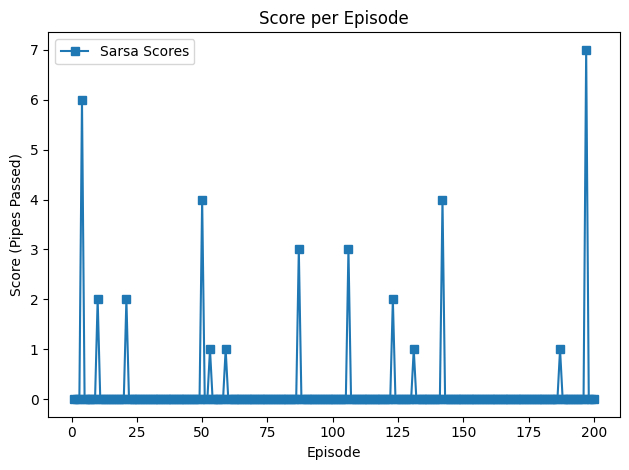

In [35]:
mc_scores = test_monte_carlo_agent(agent_MC, episodes=200, height=15, width=25, pipe_gap=6)

sarsa_scores = test_sarsa_agent(agent_Sarsa, episodes=200, height=15, width=25, pipe_gap=6)

episodes = np.arange(1, 201)

plt.plot(episodes, mc_scores, label="MC Scores", marker='o')
plt.xlabel("Episode")
plt.ylabel("Score (Pipes Passed)")
plt.title("Score per Episode")
plt.legend()

plt.tight_layout()
plt.show()

plt.plot(episodes, sarsa_scores, label="Sarsa Scores", marker='s')
plt.xlabel("Episode")
plt.ylabel("Score (Pipes Passed)")
plt.title("Score per Episode")
plt.legend()

plt.tight_layout()
plt.show()
